In [ ]:
#!pip3 install -U -r requirements.txt

In [ ]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import math


from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
CIFAR = True
if CIFAR:
  training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                    transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                    ]))
  
  validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                    transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                    ]))
else:
  training_data = datasets.MNIST(root="data", train=True, download=True,
                                    transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5), (1.0))
                                    ]))
  
  validation_data = datasets.MNIST(root="data", train=False, download=True,
                                    transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5), (1.0))
                                    ])) 


if CIFAR:
  data_variance = np.var(training_data.data / 255.0)
else:
  data_variance = np.var(training_data.data.numpy() / 255.0)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings) #self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon
        self.counter = 1.0
        self.fuz_p = 0.0
        self.encoding_indices = 0.0


       
    def fill_embeddings(self, encoded_data):
      flat_input = encoded_data.view(-1, self._embedding_dim)
      print(flat_input.shape)
      self._embedding.weight.data = flat_input.data[0:self._num_embeddings]

    def forward(self, inputs, number):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        if number>0:
          distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                      + torch.sum(self._embedding.weight**2, dim=1)
                      - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
        else:
          distances = (torch.sum(flat_input.detach()**2, dim=1, keepdim=True) 
                      + torch.sum(self._embedding.weight**2, dim=1)
                      - 2 * torch.matmul(flat_input.detach(), self._embedding.weight.t()))


        #literal distance
        


        # Encoding
        self.encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encoding_indices = self.encoding_indices
          #Multinomial
          #ng_p_batch = self.ng_p.repeat(distances.size(0),1)
          #sorted_p = torch.scatter(distances, 1, inds, ng_p_batch)
          #encoding_indices  = torch.multinomial(sorted_p, 2, replacement=True)

 
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
      
      
        # Quantize and unflatten

        Number_of_samples = 1.0 if self.training else 1.0
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)/Number_of_samples
        #quantized = torch.matmul(encodings, sorted_weights.T).view(input_shape)
        

        #ME
        #ng_normal = 0.0
        #if self.counter > 0.5:

        fuz_distances = distances
        #fuz_distances += 0.000001
        m = 2.0
        #m = m*self.counter + (1-self.counter)*1.01
        fuz = 2.0/(m-1.0)
        fuz_distances = fuz_distances**fuz
        fuz_sum = torch.sum(1.0/fuz_distances, dim=-1, keepdim=True)
        self.fuz_p= fuz_distances*fuz_sum
        self.fuz_p = 1.0/self.fuz_p
        #self.fuz_p = self.fuz_p/self.fuz_p.size(-1)
        self.fuz_p = self.fuz_p/self.fuz_p.size(-1)
        #self.fuz_p = torch.softmax(self.fuz_p**-1.4, dim=-1)
        #self.fuz_p = torch.softmax(self.fuz_p, dim=-1)
        #fuz_p = torch.softmax(fuz_p, dim=-1)



        #self.counter -= 0.00005
        #self.counter = self.counter if self.counter >0.0 else 0.0
        #self.ng_p = torch.exp(-1*self.ng_c/lamda).to(device)
        #self.ng_p = self.ng_p/self.ng_p.size(0)
        #self.ng_p = self.ng_p/torch.sum(self.ng_p)

        fuz_expectation = torch.sum(self.fuz_p*distances.to(device))
        #END ME
        
        # Loss
        #e_latent_loss = F.mse_loss(quantized.detach(), inputs)

        q_latent_loss = F.mse_loss(quantized, inputs.detach())

        
       #loss = self._commitment_cost * e_latent_loss + ng_normal #q_latent_loss #ng_normal 
        loss =  fuz_expectation #q_latent_loss #ng_normal 
        if number<0:
          loss=loss.detach()
          
        #loss = loss.detach()
        #loss = ng_normal

        #if self.iterations > 6000:
        #  loss = 0.0
        #loss = ng_normal #q_latent_loss #ng_normal 

        # Straight Through Estimator

        #quantized = inputs + (quantized - inputs).detach()
        if number>0:
          quantized = inputs + (quantized - inputs).detach()
        else:
          quantized = inputs
        
        #quantized = quantized.detach()
        #quantized = inputs + (ng_expectations
        
        #if self.iterations > 6000:
        #  quantized = quantized.detach()
        #quantized = inputs + ng_normal - (inputs).detach()
        ###PERPEXILITY
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        #########perplexity = torch.tensor([1])
        ####END PERPELXITLITY
        
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, 0.0



class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, out_channels=3):
        super(Decoder, self).__init__()
        
        print(in_channels)
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        #self._residual_stack2 = ResidualStack(in_channels=num_hiddens,
        #                                     num_hiddens=num_hiddens,
        #                                     num_residual_layers=num_residual_layers,
        #                                     num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=out_channels,#CHANNELS
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        #x = self._residual_stack2(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

#config
batch_size = 32
num_training_updates = 2*15000
epochs = 20

alpha = 10
penality = False
lamda0 = 4
if CIFAR:
  num_hiddens = 128
  num_residual_hiddens = 32
  num_residual_layers = 2

  embedding_dim = 32
  #embedding_dim = 32
  #num_embeddings = 512
  num_embeddings = 512
else:
  num_hiddens = 128
  num_residual_hiddens = 32
  num_residual_layers = 2

  embedding_dim = 32
  #num_embeddings = 512
  num_embeddings = 2


commitment_cost = 1

decay = 0.99

learning_rate = 1e-3
#learning_rate = 3e-4


training_loader = DataLoader(training_data, 
                             batch_size=batch_size, 
                             shuffle=True,
                             pin_memory=True)


validation_loader = DataLoader(validation_data,
                               batch_size=32,
                                shuffle=True,
                               pin_memory=True)


class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, training_data, decay=0,in_channels=3, out_channels=3, num_levels=1 ):
        super(Model, self).__init__()
        self._num_levels = num_levels
        
        self._encoder = Encoder(in_channels, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                            commitment_cost, decay)
        print("test xxxx: ", self._num_levels)
        print("test xxxx2: ", embedding_dim)
                        
        self._decoder = Decoder(self._num_levels*embedding_dim,
                                self._num_levels*num_hiddens, 
                                self._num_levels*num_residual_layers, 
                                self._num_levels*num_residual_hiddens, out_channels)
        self._a1 = torch.nn.Parameter(2*torch.ones(1, requires_grad=True))
        self._a2 = torch.nn.Parameter(2*torch.ones(1, requires_grad=True))
        sample = DataLoader(validation_data,
                               batch_size=num_embeddings,
                               shuffle=True,
                               pin_memory=True)
        (sample, _) = next(iter(sample))
        print(sample.shape)
        encode = self._encoder(sample).detach()
        encode = self._pre_vq_conv(encode)
        print(encode.shape)
        self._vq_vae.fill_embeddings(encode)
        

    def forward(self, x, number, pre_latent=None):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z, number)
        if self._num_levels >1:
          quantized = torch.cat([quantized, pre_latent], dim=1)

        x_recon = self._decoder(quantized)
        
        return loss, x_recon, quantized, perplexity

models = []
if CIFAR:
  models.append( Model(num_hiddens, num_residual_layers, num_residual_hiddens,
                num_embeddings, embedding_dim, 
                commitment_cost, training_data, decay).to(device)
  )

  models.append(
    Model(num_hiddens, num_residual_layers, num_residual_hiddens,
                num_embeddings, embedding_dim,
                commitment_cost, training_data, decay, num_levels=2).to(device)
  )


  models.append(
    Model(num_hiddens, num_residual_layers, num_residual_hiddens,
                num_embeddings, embedding_dim,
                commitment_cost, training_data, decay, num_levels=3).to(device)
  )
else:
  model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
                num_embeddings, embedding_dim, 
                commitment_cost, training_data, decay,out_channels=1, in_channels=1).to(device)



def train():
  for m in models:
    m.train()

def eval():
  for m in models:
    m.eval()

def forward(x):
  num = 1.0
  data = x
  pre_latent = None
  eval()
  for model in models:
    vq_loss, data_recon, quantized, perplexity = model(data,num, pre_latent= pre_latent)
    pre_latent = quantized
  return data_recon

def parameters():
  params = []
  for m in models:
    params += m.parameters()
  return params

one_optemizer = True
if one_optemizer:
  optimizer = optim.Adam(parameters(), lr=learning_rate, amsgrad=False)
else:
  optimizer = [optim.Adam(m.parameters(), lr=learning_rate, amsgrad=False) for m in models]


test xxxx:  1
test xxxx2:  32
32
torch.Size([512, 3, 32, 32])
torch.Size([512, 32, 8, 8])
torch.Size([32768, 32])
test xxxx:  2
test xxxx2:  32
64
torch.Size([512, 3, 32, 32])
torch.Size([512, 32, 8, 8])
torch.Size([32768, 32])
test xxxx:  3
test xxxx2:  32
96
torch.Size([512, 3, 32, 32])
torch.Size([512, 32, 8, 8])
torch.Size([32768, 32])


In [ ]:
for m in models:
  m.train()
train_res_recon_error = [[] for i in range(len(models))]
train_res_perplexity = [[] for i in range(len(models))]
quantize_error = []
Lagrangian = True
for epoch in range(epochs):
  for i, (data, _) in enumerate(training_loader):
    data = data.to(device)
    if one_optemizer:
      optimizer.zero_grad()
    else:
      for o in optimizer:
        o.zero_grad()

    #if epoch>2 :
    #  num = 1.0
    #else:
    #  mum = -1.0
    num=1
    loss = 0.0
    recon_error = 0.0
    pre = None
    
    for idx, model in enumerate(models):
      vq_loss, data_recon, quantized, perplexity = model(data, num, pre)

      if one_optemizer:
        pre = quantized
      else:
        pre = quantized.detach()
      recon_error = F.mse_loss(data_recon, data) / data_variance
      p1 = F.sigmoid(model._a1)
      p2 = F.sigmoid(model._a2)
      if one_optemizer:
        loss += (vq_loss + recon_error)*(idx+1)
      else:
        loss = vq_loss +recon_error
        loss.backward()
        optimizer[idx].step()
      train_res_perplexity[idx].append(perplexity.item())
      train_res_recon_error[idx].append(recon_error.item())
     
  
    if one_optemizer:
      loss.backward()

      optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())
    #quantize_error.append(q_latent_loss.item())

    period = 100

    if (i+period) % period == 0:
        print('%d epoch' % (epoch+1))
        print('%d iterations' % (i+1))
        for idx in range(len(models)):
          print('recon_error {}: %.3f'.format(idx) % np.mean(train_res_recon_error[idx][-period:]))
          print('perplexity{}: %.3f'.format(idx) % np.mean(train_res_perplexity[idx][-period:]))
        print('a1', model._a1)
        print('a2', model._a2)
        #print('vq_loss: %.3f' % vq_loss)
        #print('q_latent_loss: {}'.format(np.mean(quantize_error[-period:])))
        #print('ng_p', torch.sort(model._vq_vae.fuz_p)[0])
        print('ng_p sum', torch.sum(model._vq_vae.fuz_p,dim=-1))
        #print('ng_p', model._vq_vae.encoding_indices)
        #print('ng_p', torch.sort(model.[1])
        print()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1 epoch
1 iterations
recon_error 0: 0.074
perplexity0: 235.939
recon_error 1: 0.037
perplexity1: 54.157
recon_error 2: 0.028
perplexity2: 22.177
a1 Parameter containing:
tensor([2.], device='cuda:0', requires_grad=True)
a2 Parameter containing:
tensor([2.], device='cuda:0', requires_grad=True)
ng_p sum tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020], device='cuda:0',
       grad_fn=<SumBackward1>)

1 epoch
101 iterations
recon_error 0: 0.087
perplexity0: 244.353
recon_error 1: 0.042
perplexity1: 57.859
recon_error 2: 0.032
perplexity2: 23.763
a1 Parameter containing:
tensor([2.], device='cuda:0', requires_grad=True)
a2 Parameter containing:
tensor([2.], device='cuda:0', requires_grad=True)
ng_p sum tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020], device='cuda:0',
       grad_fn=<SumBackward1>)

1 epoch
201 iterations
recon_error 0: 0.086
perplexity0: 244.342
recon_error 1: 0.042
perplexity1: 58.958
recon_error 2: 0.030
perplexity2: 24.292
a1 Parameter contai

KeyboardInterrupt: ignored

## Plot Loss

train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

NameError: ignored

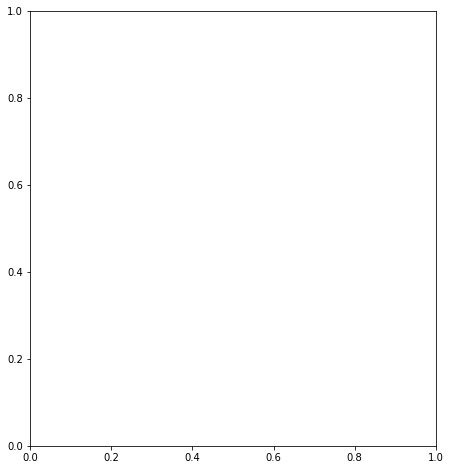

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [ ]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

valid_reconstructions = forward(valid_originals)

In [ ]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
train_reconstructions = forward(train_originals)

In [ ]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


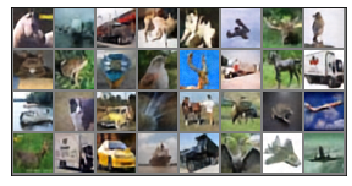

In [ ]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

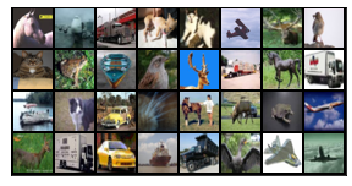

In [ ]:
show(make_grid(valid_originals.cpu()+0.5))

## View Embedding

In [ ]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

In [ ]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)